# Calculating the R Factor over the Zambezi River
The Revised Universal Soil Loss Equation [Renard et al., (1997](https://www.ars.usda.gov/ARSUserFiles/64080530/RUSLE/AH_703.pdf) requires computing rainfall erosivity (R-factor) over the area you are interested in. From the RUSLE Manual:  
"Mathematically, R is: 

\begin{align}
R=\frac{1}{n}\sum\limits_{j=1}^{n}\Bigg[\sum\limits_{k=1}^{m}(E)(I_{30})_k\Bigg]
\end{align}

Where:  
$E$=total storm kinetic energy  
$I_{30}$= maximum 30-min rainfall intensity,  
$j$ = index of number of years used to produce average,  
$k$ = index of number of storms in each year,  
$n$ = number of years used to obtain average R,  
$m$ = number of storms in each year, and  
$R$ = average annual rainfall erosivity.  
<br>
\begin{align}
EI =(E)(I_{30}) = \Bigg[\sum\limits_{k=1}^{m}e_r \Delta V_r\Bigg]I_{30}
\end{align}

Where:  
$e_r$= rainfall energy per unit depth of rainfall per unit area ft•tonf•acre$^{-1}$•in$^{-1}$, and  
$\Delta$V$_r$= depth of rainfall for the rth increment of the storm hyetograph which is divided into m parts, each with essentially constant rainfall intensity (in).  
<br>
Unit energy, $e$, is a function of rainfall intensity and is computed as: 
\begin{align}
e_r = 1099 [ 1-0.72 exp ( -1.27i_r)]
\end{align}
and  
\begin{align}
i_r=\frac{\Delta V_r}{\Delta t_r}
\end{align}

Where:  
$\Delta t_r$. = duration of the increment over which rainfall intensity is considered to be constant (h), and
$i_r$ = rainfall intensity (in • h$^{-1}$)."  


#### Note: the manual dictates 30 minute maximum storm intensities, so we will need some highly resolved data!
## Import Packages

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import pandas as pd
import seaborn as sns
import numpy as np
import xarray as xr
import netCDF4
from os import listdir
import os
from IPython.display import clear_output
import time
import nc_time_axis
import cftime

In [3]:
figure_path='/Users/danielbabin/GitHub/Zambezi_RUSLE/Figures/'
data_path='/Users/danielbabin/Documents/LamontColumbia/U1477/Data/'
geog_path='/Users/danielbabin/GitHub/Zambezi_RUSLE/Data/Shapes/'
hhpath='/Users/danielbabin/Documents/LamontColumbia/U1477/Data/HHRainfall2016/'

## Import Zambezi Shapes

In [4]:
basin=shpreader.Reader(geog_path+'zambeziBasin/zambeziBasin.shp')
river=shpreader.Reader(geog_path+'zambeziRiver/zambeziRiver.shp')

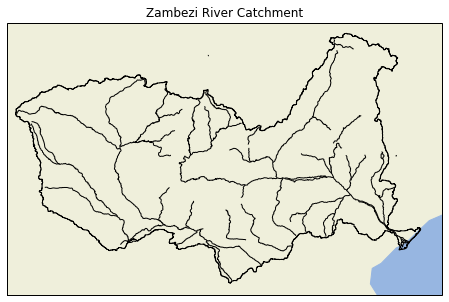

In [5]:
fig = plt.figure(figsize=[10, 5])
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.set_extent([18, 38, -8.5, -21])
ax.add_geometries(basin.geometries(),ccrs.PlateCarree(),facecolor='None',edgecolor='k')
ax.add_geometries(river.geometries(),ccrs.PlateCarree(),facecolor='None',edgecolor='k')
ax.set_title('Zambezi River Catchment');

## Which Year?
This step probably isn't really necessary, because research shows RUSLE is pretty good at making estimates in an average sense, regardless of what year you choose. So, you could think of it as some prelimiary analysis. I'm going to try to choose an year with an average amount of rainfall. I'm using the monthly means from NOAA's PrecRec/L.
### Import 1x1 resolution PREC/L

In [6]:
prec = xr.open_dataset(data_path+'precip.mon.mean.1x1.nc')
preslc=prec.sel(time=slice('1990-01-01', '2020-01-01')).sel(lon=slice(18,38),lat=slice(-8.5,-21))

In [7]:
years=np.arange(1990,2021,1)

In [8]:
annuals=preslc.groupby('time.year').mean('time')
climatology=preslc.mean('time')

### Compute Precipitation Climatology

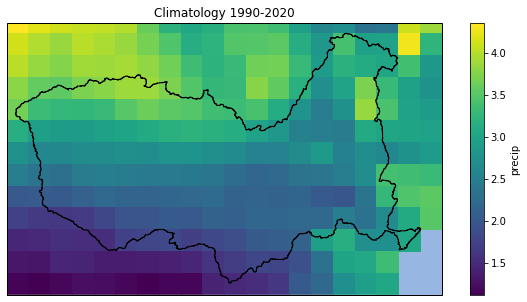

In [9]:
fig = plt.figure(figsize=[10, 5])
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.set_extent([18, 38, -8.5, -21])
ax.add_geometries(basin.geometries(),ccrs.PlateCarree(),facecolor='None',edgecolor='k')
ax.set_title('Zambezi River Catchment');
climatology.precip.plot()
ax.set_title('Climatology 1990-2020');

### Vizualize Anomalies for a Single Year

In [10]:
anoms=annuals-climatology

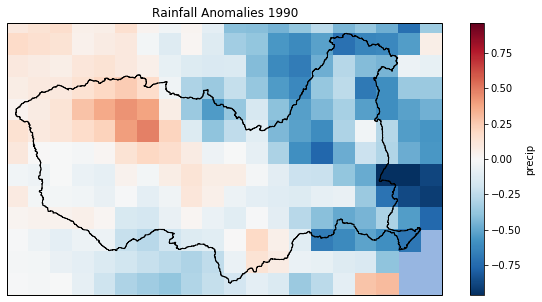

In [11]:
fig = plt.figure(figsize=[10, 5])
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.set_extent([18, 38, -8.5, -21])
ax.add_geometries(basin.geometries(),ccrs.PlateCarree(),facecolor='None',edgecolor='k')
ax.set_title('Zambezi River Catchment');
anoms.sel(year=1990).precip.plot()
ax.set_title('Rainfall Anomalies 1990');

### Summed rainfall anomalies as a time series

(-200, 150)

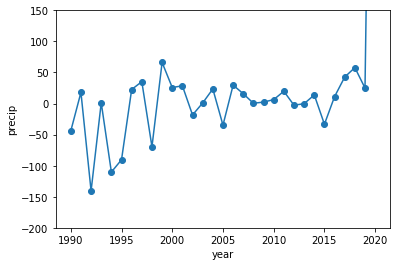

In [12]:
one_dim_anoms=anoms.sum(dim=['lat','lon'])
fig,ax=plt.subplots()
one_dim_anoms.precip.plot(ax=ax,marker='o')
ax.set_ylim(-200,150)

# 2016 Half Hour Rainfall Data
I chose to work with 2016, because it was recent, and looked to be pretty average. I wish I could do more years, but the data is pretty big. It was 16 Gb for all of the files in the orignal dataset I pulled form NOAA. I have a notebook where I read this as an MFDataset and wrote it to a single netcdf to save time and storage space. That file is only 5 Gb.

In [13]:
hhp=xr.open_dataset(hhpath+'zamHHprecip2016.nc',chunks='auto')
datetimeindex=hhp.indexes['time'].to_datetimeindex(unsafe=True)
hhp['time'] = datetimeindex

In [14]:
def plotBasin():
    ax.coastlines(lw=.5,color='k',resolution='10m')
    ax.add_geometries(basin.geometries(),ccrs.PlateCarree(),facecolor='None',edgecolor='k',lw=.5)
    ax.set_extent([18, 38, -8.5, -21])
    ax.tick_params(top=True,right=True)
    ax.set_xticks([20,25,30,35])
    ax.set_xticklabels([20,25,30,35])
    ax.set_yticks([-10,-12,-14,-16,-18,-20])
    ax.set_yticklabels([-10,-12,-14,-16,-18,-20])

### Visualize slices of the data
There are 17k of these panes of rainfall intensity in this dataset, gridded at .1x.1 lat lon.

/Users/danielbabin/opt/anaconda3/lib/python3.7/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


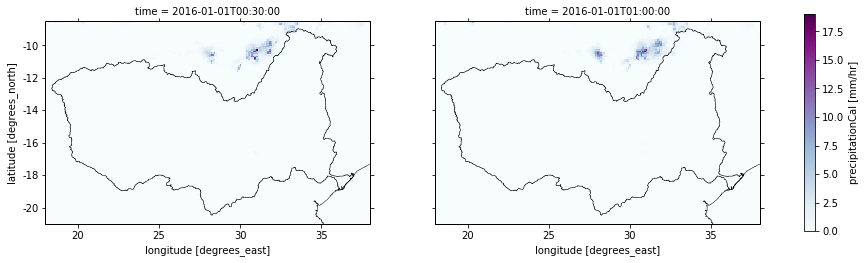

In [15]:
hhp4=hhp.isel(time=slice(0,2))
g=hhp4.precipitationCal.plot(x="lon", y="lat", col="time",transform=ccrs.PlateCarree(),
                             subplot_kws={"projection": ccrs.PlateCarree()},cmap='BuPu',figsize=(16,4))
for ax in g.axes.flat:
    plotBasin()

## Convert Depth
There are some computations that require a "depth" of rainfall instead of an intensity and that's easy to calculate given the sampling rate, so I just do that now and visualize it.

In [16]:
hhp['mm']=hhp['precipitationCal']*.5

/Users/danielbabin/opt/anaconda3/lib/python3.7/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


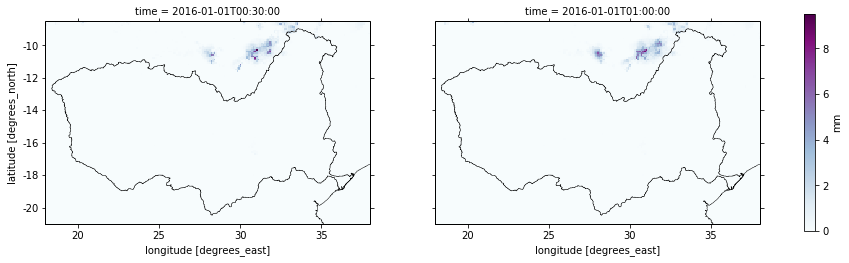

In [17]:
hhp4=hhp.isel(time=slice(0,2))
g=hhp4.mm.plot(x="lon", y="lat", col="time",transform=ccrs.PlateCarree(),
                             subplot_kws={"projection": ccrs.PlateCarree()},cmap='BuPu',figsize=(16,4))
for ax in g.axes.flat:
    plotBasin()

## Identify Storms
I need to separate all the storms individually so I can get the maximum intensity from each one. Maybe there's an easier way to do this! But that's what I came up with. Below is what the time series looks like from a single grid cell. 

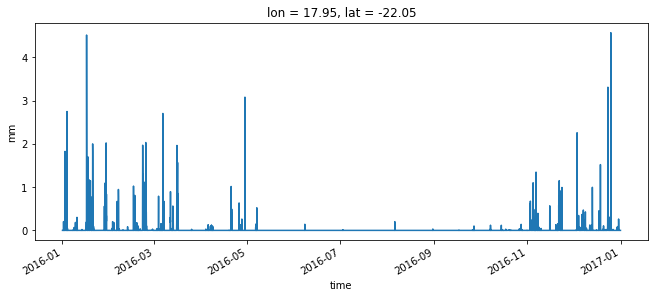

In [18]:
hhp.isel(lon=0,lat=0).mm.plot(figsize=(11,4))

Here's zooming in on the first few hours to see how much structure the data really has.

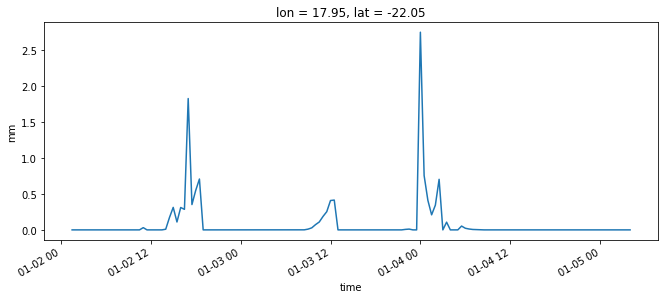

In [19]:
hhp.isel(lon=0,lat=0,time=slice(50,200)).mm.plot(figsize=(11,4))

## Strategy for getting storm statistics
I want find how many storms are in each of the cells and give every storm an ID number, which starts from 0 in a cell and counts up to the last storm in a cell. The next cell will also start from 0 and may have a different number data points in specific storms, or even a different number of storms total. I'll give every data point in every storm that ID number in some different variable, so I can group those data and find the maximum value from the group. To do this, I'll need to find the start and end of every storm so I can make slices. First I make a boolean variable for "raining". I'll use that to identify starts and finishes of storms. It would be nice at that point to use that data to sice the original dataframe and use statistics on the x array object, but I can't figure out how to work with the uneven shape of the data. So, I group the storms by their lengths and store those data in separate arrays to keep them square for doing the statistics in a vectorized way. 
### Boolean "Rainfalling" Variable
My idea to separate the storms involves creating some new variables, all boolean. One variable is just TRUE when it's raining and FALSE when it's not.

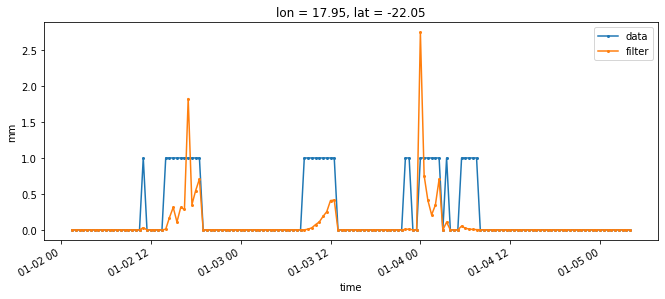

In [20]:
hhp['rainfalling']=xr.ufuncs.isfinite(hhp.where(hhp.mm>0).mm).compute()
fig,ax=plt.subplots(figsize=(11,4))
hhp.isel(lon=0,lat=0,time=slice(50,200)).rainfalling.compute().plot(label='data',ax=ax,marker='o',ms=2)
hhp.isel(lon=0,lat=0,time=slice(50,200)).mm.plot(label='filter',ax=ax,marker='o',ms=2)
ax.legend()

### Starts and Finishes
This code will make two new variables that indicate if a time at a grid cell is a beginning or end of of a storm.

In [21]:
hhp['finishes']=((hhp.rainfalling.shift(time=-1,fill_value=False)==False)&(hhp.rainfalling==True)).compute()
hhp['starts']=((hhp.rainfalling.shift(time=1,fill_value=False)==False)&(hhp.rainfalling==True)).compute()

In [22]:
slc=hhp.isel(lon=200,lat=26,time=slice(4045,4172))
starts=slc.where(slc.starts==True,drop=True).time.values
finishes=slc.where(slc.finishes==True,drop=True).time.values

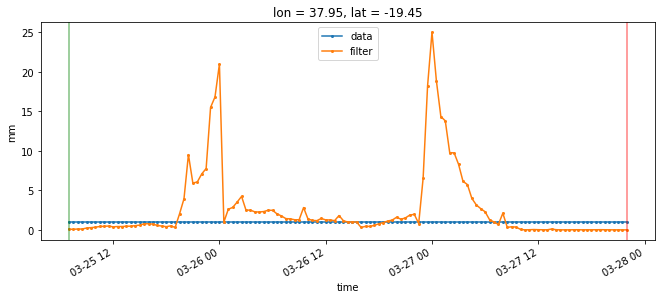

In [23]:
fig,ax=plt.subplots(figsize=(11,4))
slc.rainfalling.plot(label='data',ax=ax,marker='o',ms=2)
slc.mm.plot(label='filter',ax=ax,marker='o',ms=2)
for i in range(len(starts)):
    ax.axvline(starts[i],c='green',alpha=.5)
    ax.axvline(finishes[i],c='red',alpha=.5)
ax.legend()

### At this point, i can count the number of storms in each cell

In [24]:
hhp['nStorms']=hhp.finishes.sum(dim='time').transpose().compute()

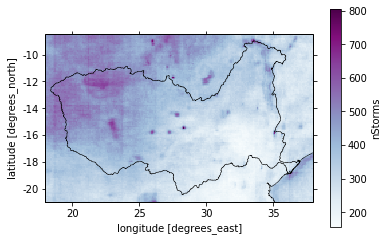

In [25]:
ax=plt.axes(projection=ccrs.PlateCarree())
hhp['nStorms'].plot(transform=ccrs.PlateCarree(),cmap='BuPu',ax=ax)
ax.coastlines(lw=.5,color='k',resolution='10m')
ax.add_geometries(basin.geometries(),ccrs.PlateCarree(),facecolor='None',edgecolor='k',lw=.5)
ax.set_extent([18, 38, -8.5, -21])
ax.tick_params(top=True,right=True)
ax.set_xticks([20,25,30,35])
ax.set_xticklabels([20,25,30,35])
ax.set_yticks([-10,-12,-14,-16,-18,-20])
ax.set_yticklabels([-10,-12,-14,-16,-18,-20]);

### Separate Each Storm
This is where it gets tricky. Because every grid cell could have a different number of storms, I couldn't find a way to efficiently keep this operation in x array. I think x array is good for data with a nice even shape. So, here I put each array of interest into numpy.

In [26]:
starts=hhp['starts'].values
finishes=hhp['finishes'].values
rates=hhp['precipitationCal'].values
energy=0.29*(1-0.72*np.exp(-0.051*hhp['precipitationCal'])).values
mms=hhp['mm'].values

In [27]:
startargs=np.array(np.where(starts)).transpose()
finishargs=np.array(np.where(finishes)).transpose()

There are 9.7 million storms across all the grid cells the entire basin.

In [28]:
len(startargs)

9732041

This code makes a dataframe with every storm in the rows, and its start index (in integers, not datetime), finish index, and the number of measurements in the storm (duration) for every one. 

In [29]:
ss=pd.DataFrame(startargs,columns=['stime','lon','lat']).sort_values(by=['lon','lat']).set_index(['lon','lat'])
fs=pd.DataFrame(finishargs,columns=['ftime','lon','lat']).sort_values(by=['lon','lat']).set_index(['lon','lat'])
sfargs=ss.copy()
sfargs['ftime']=fs['ftime']
sfargs['duration']=sfargs['ftime']-sfargs['stime']
sfargs=sfargs[sfargs['duration']!=0]

In [30]:
sfargs.head()

stime  ftime  duration
lon lat                        
0   0       75     84         9
    0      112    120         8
    0      139    140         1
    0      143    148         5
    0      154    158         4

Lengths has all of the lengths of different storms in the dataset. The longest one was 126 measurements, or 63 hours.

In [31]:
lengths=np.sort(sfargs['duration'].unique())
lengths

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  98,  99, 100, 102, 103, 104, 105, 106,
       108, 110, 111, 112, 113, 114, 115, 116, 119, 126])

Counts has the number of storms that have each of those lengths

In [32]:
counts=sfargs.groupby(by='duration').count()['stime']
counts

duration
1      1279146
2       880431
3       655408
4       622091
5       545076
        ...   
114          1
115          2
116          1
119          3
126          1
Name: stime, Length: 114, dtype: int64

sortedstartargs makes a dictionary of numpy arrays that have the dimensions rows = number of storms of a given length x columns = measurements from that storm.

In [33]:
sortedstartargs={}
for i,length in enumerate(lengths):
    sortedstartargs[length]=sfargs[sfargs['duration']==length].reset_index()[['stime','lon','lat']].values

This code actually takes that matrix of start args and add the lat lon back to the vector and then actually does the slicing of the data using the indexes/arguements we've been collecting.

In [34]:
stormargs={}
stormmms={}
stormrates={}
stormenergy={}
for length in lengths:   
    stormargs[length]=sortedstartargs[length]
    for i in np.arange(length):
        stormargs[length]=np.vstack([stormargs[length],sortedstartargs[length]+[i,0,0]])
    stormmms[length]=mms[stormargs[length][:,0],
                          stormargs[length][:,1],
                          stormargs[length][:,2]].reshape(counts.loc[length],length+1)
    stormrates[length]=rates[stormargs[length][:,0],
                          stormargs[length][:,1],
                          stormargs[length][:,2]].reshape(counts.loc[length],length+1)
    stormenergy[length]=energy[stormargs[length][:,0],
                          stormargs[length][:,1],
                          stormargs[length][:,2]].reshape(counts.loc[length],length+1)

### Get storm statistics
We need the total precipitation per storm in mm, the max intensity per storm, and the total kinetic energy per storm. 

In [35]:
total_precip_perstorm_dict={}
max_intensities_dict={}
total_energy_perstorm_dict={}

total_precip_perstorm=np.zeros((1,4))
max_intensities=np.zeros((1,4))
total_energy_perstorm=np.zeros((1,4))

for length in lengths:
    total_precip_perstorm_dict[length]=np.hstack([stormmms[length].sum(axis=1)[:,None],sortedstartargs[length]])
    max_intensities_dict[length]=np.hstack([stormrates[length].max(axis=1)[:,None],sortedstartargs[length]])
    total_energy_perstorm_dict[length]=np.hstack([stormenergy[length].sum(axis=1)[:,None],sortedstartargs[length]])
    
    total_precip_perstorm=np.vstack([total_precip_perstorm,total_precip_perstorm_dict[length]])
    max_intensities=np.vstack([max_intensities,max_intensities_dict[length]])
    total_energy_perstorm=np.vstack([total_energy_perstorm,total_energy_perstorm_dict[length]])
    
total_precip_perstorm=total_precip_perstorm[1:]
max_intensities=max_intensities[1:]
total_energy_perstorm=total_energy_perstorm[1:]

This code reorganizes this into 2D matrices again (dataframes)

In [36]:
total_precip_perstorm=pd.DataFrame(total_precip_perstorm,columns=['depth (mm)','start','lat','lon'])
max_intensities=pd.DataFrame(max_intensities,columns=['I_30','start','lat','lon'])
total_energy_perstorm=pd.DataFrame(total_energy_perstorm,columns=['e_k','start','lat','lon'])

for df in [total_precip_perstorm,max_intensities,total_energy_perstorm]:
    df[['start','lat','lon']]=df[['start','lat','lon']].astype(int)
total_precip_perstorm=total_precip_perstorm.sort_values(by=['lon','lat']).set_index(['lon','lat'])
max_intensities=max_intensities.sort_values(by=['lon','lat']).set_index(['lon','lat'])
total_energy_perstorm=total_energy_perstorm.sort_values(by=['lon','lat']).set_index(['lon','lat'])

## Calculate Storm Energy and R
I am doing this following the equations listed at the top of the page
### Unit Conversion
#### Area
0.1&deg; lat/lon = 111 m  
111$^2$ = 12321 m$^2$  
12321 m$^2$ = 1.2321 hectares

#### Rates
1 in/hour = 25.4 mm/hour

In [37]:
total_energy_perstorm['e_r']=total_energy_perstorm['e_k']/total_precip_perstorm['depth (mm)']/1.2321

In [38]:
EdotI30=total_energy_perstorm['e_r']*max_intensities['I_30']
R=EdotI30.groupby(by=['lon','lat']).sum().reset_index().pivot(columns='lat',index='lon')

In [39]:
R.columns=hhp.lon.values
R.index=hhp.lat.values

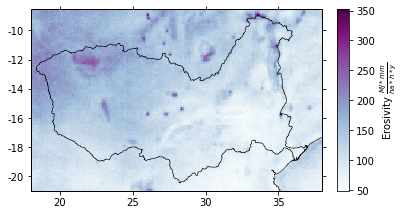

In [46]:
fig,ax=plt.subplots()
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax=plt.axes(projection=ccrs.PlateCarree())
axins=inset_axes(ax, width="7%",height="95%",loc=3,bbox_transform=ax.transAxes,
                        bbox_to_anchor=(1.05, 0, .6, 1.05),borderpad=0)
cax=ax.pcolormesh(R.columns,R.index,R.values,transform=ccrs.PlateCarree(),cmap='BuPu')
cbar = fig.colorbar(cax,cax=axins,label=r'Erosivity $\frac{MJ*mm}{ha*h*y}$')
ax.coastlines(lw=.5,color='k',resolution='10m')
ax.add_geometries(basin.geometries(),ccrs.PlateCarree(),facecolor='None',edgecolor='k',lw=.5)
ax.set_extent([18, 38, -8.5, -21])
ax.tick_params(top=True,right=True)
ax.set_xticks([20,25,30,35])
ax.set_xticklabels([20,25,30,35])
ax.set_yticks([-10,-12,-14,-16,-18,-20])
ax.set_yticklabels([-10,-12,-14,-16,-18,-20]);
plt.subplots_adjust(right=.8,left=)
fig.savefig(figure_path+'R_factor.png',dpi=300)

In [43]:
RUSLE_path='/Users/danielbabin/GitHub/Zambezi_RUSLE/Tables/'

In [44]:
R.to_csv(RUSLE_path+'R_factor.csv')